# Tree sequence workshop- Part 3: Inference

### Friday 14 December

Welcome to the tree sequence workshop. Today we will give you an overview of the tree sequence data structure, the $\texttt{msprime}$ coalescent simulator, and our efficient inference framework: $\texttt{tsinfer}$. 

# Outline

1. [<span style="color: gray">The tree sequence format</span>](ts_workshop_part1.ipynb#ts)
2. [<span style="color: gray">Simulations (msprime & slim)</span>](ts_workshop_part2.ipynb#msprime)
3. [<span style="color: gray">Calculating statistics with tree sequences</span>](ts_workshop_part2.ipynb#stats)
4. [Inferring tree sequences (tsinfer)](#tsinfer)
5. [Metadata in tree sequences](#metadata)
6. [References and Documentation](#ref)

In [81]:
import json
from IPython.display import SVG, display
import numpy as np
import seaborn as sns
import scipy
import pandas as pd
import matplotlib.pyplot as plt
from ete3 import Tree, TreeStyle, TextFace

import msprime as tskit
import tsinfer

In [3]:
%%html
<style>aside {color:grey;}</style>

<a id='tsinfer'></a>
# 4. Genealogical inference

Simulating a tree sequence is relatively simple compared to *inferring* a tree sequence from existing data. The [tsinfer software](https://tsinfer.readthedocs.io/en/latest/), currently in active development, implements a heuristic algorithm which does this in a scalable manner.

`Tsinfer` (pronounced t-s-infer) is comparable in some ways to other ancestral inference software such as [ARGweaver](https://doi.org/10.1371/journal.pgen.1004342), [Relate](https://myersgroup.github.io/relate/), and [Rent+](https://doi.org/10.1093/bioinformatics/btw735). However, it differs considerably in approach and scalability. Note that none of these other software packages produce tree sequences as output, although is possible (but unsupported and tedious) to convert their output to tree sequences. Also note that `tsinfer` produces trees with a relatively accurate topology, but unlike other ancestral inference tools, makes no attempt at the moment to produce precise branch length estimates.

AN important restriction is that `tsinfer` requires phased sample sequences with known ancestral states for each variant. It also works better with full sequence data than with data from scattered target SNPs (e.g. as obtained from SNP chips).

## Tsinfer overview

The best current description of `tsinfer` in the [preprint on Biorxiv](https://www.biorxiv.org/content/early/2018/11/01/458067).

The key `tsinfer`'s scalability is that, rather than compare sample genomes with each other in a pairwise manner, we use them to reconstruct the genomic sequence of their **ancestors**. These ancestors can consist of partial chunks of sequence. As demonstrated below with simulated data, the older the ancestor, the shorter the inherited chunks (or "ancestral haplotypes") are likely to be. This means that we should not need to reconstruct long ancient haplotypes, making our job much easier (note the log-log scale on the plot).

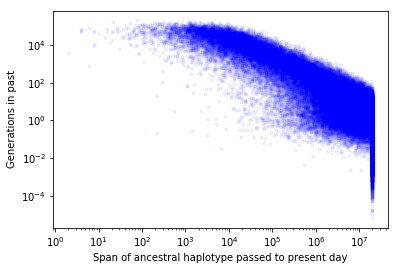

In [66]:
# load the huge simulation used previously, and plot lengths of ancestral haplotype which have made it to the present
big_sim = tskit.load("data/large-ts-no-mutations.trees")
node_lengths = np.zeros(big_sim.num_nodes, dtype=np.int)
for e in big_sim.edges():
    node_lengths[e.parent] += (e.right-e.left)

fig, ax = plt.subplots()
plt.loglog(node_lengths, big_sim.tables.nodes.time, 'b.', alpha=0.05)
t = ax.set_xlabel('Span of ancestral haplotype passed to present day')
t = ax.set_ylabel('Generations in past')

Once we have reasonable chunks of ancestral haplotype sequence (and a rough age order) we can take advantage of a modified version of the Li & Stephens matching algorithm to calculate which ancestors immediately descend (or "copy") from which others. Once we have done this, we can apply the same method to deduce from which ancestors the current samples descend. This obviates the need to make pairwise comparisons between samples, which is computationally extortionate. Another performance gain is obtained because the "copying order" created during the matching process directly corresponds to the edges in a tree sequence (in fact, the tree sequence format is created during the matching process, and tree sequence technology is integral to the fast performance of the matching algorithm).

## Algorithm details
The `tsinfer` method is split into two main parts: 
1. the reconstruction and time ordering of ancestral haplotypes and 
2. the inference of the copying process. 

Via simulation, we can show that using "perfect ancestors" in the copying process results in perfect inference of the copying process. Thus, although part 2 is the most technically challenging part of the algorithm, we suspect that most inaccuracy in our algorithm can be traced to assumptions and simplifications made in part 1. For this reason we mainly focus on the details of ancestral haplotype reconstruction and ordering.

The preprint contains the following schematic overview of the method, with part 1 on the left and part 2 on the right.

Figure 2: <img src="images/tsinfer-schematic.png">

### Part 1: Ancestor reconstruction

Ancestors are reconstructed under an infinite sites assumption. I.e. individuals which share a variant do so because they have all inherited it from a common ancestor.

Figure S2: <img style="height: 600px" src="images/ancestor-reconstruction.png">

Age order assumptions

### Part 2: Copying path inference
Some detail about Li & Stephens here

Some detail about path compression.

Note that it may not matter (apart from for performance) if we reconstruct ancestors in part (1) that are too long

### Inference accuracy
There are no established ways to compare one tree sequence (or ARG). However, there are many ways to compare trees. 

Note that the KC methods is built in to tsinfer.

## Hands-on with tsinfer
Let's try out tsinfer using the simulation of the out-of-Africa three population model of recent human evolution. We start by loading the tree sequence we previously generated:

In [5]:
ooa_simulated = tskit.load("data/OOA.trees")

We remind ourselves what the resulting six marginal trees looked like (this time with mutations added)

------------------------------------------------------------
Marginal Tree span: (0.0, 492.9612682883072)


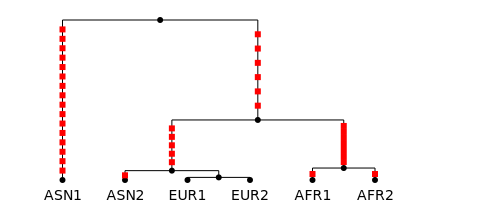

------------------------------------------------------------
Marginal Tree span: (492.9612682883072, 1664.7747942862973)


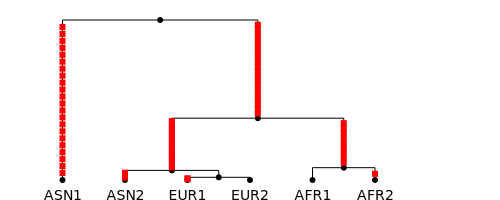

------------------------------------------------------------
Marginal Tree span: (1664.7747942862973, 2844.0483398372417)


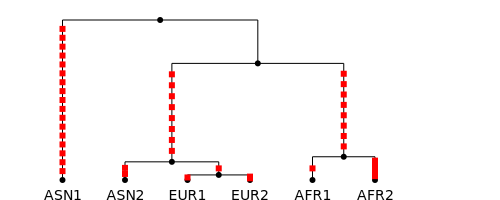

------------------------------------------------------------
Marginal Tree span: (2844.0483398372417, 3008.07310687566)


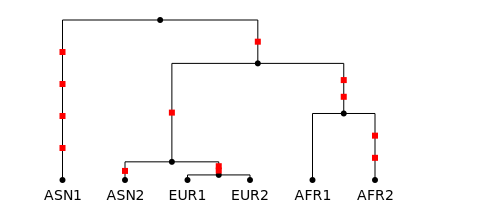

------------------------------------------------------------
Marginal Tree span: (3008.07310687566, 3615.6123954839104)


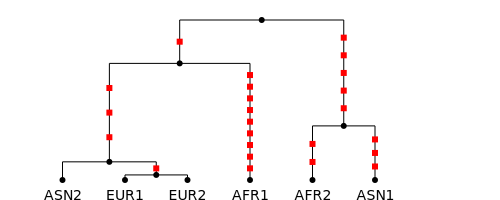

------------------------------------------------------------
Marginal Tree span: (3615.6123954839104, 5000.0)


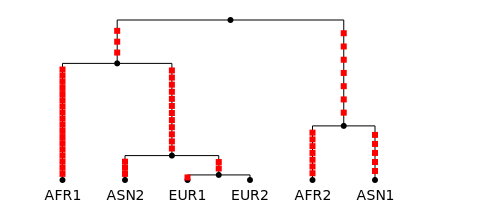

In [10]:
for tree in ooa_simulated.trees():
    print("---"*20)
    print("Marginal Tree span:", tree.get_interval())
    display(SVG(tree.draw(mutation_labels={},
        node_labels={0:"AFR1",1:"AFR2", 2:"EUR1",3:"EUR2",4:"ASN1",5:"ASN2"},
        width=500)))
    

We will take the variants from this simulation, and see if we can use them to infer the true, simulated trees. The first step of tsinfer is to create a `SampleData` file. With real data we would create this site-by-site from e.g. a VCF or BGEN file. Here we can can create it by iterating over the variants in the simulated tree sequence:

In [11]:
with tsinfer.SampleData(
        path="data/ooa_simulation.samples", sequence_length=ooa_simulated.sequence_length,
        num_flush_threads=2) as ooa_sample_data:
    for var in ooa_simulated.variants():
        ooa_sample_data.add_site(var.site.position, var.genotypes, var.alleles)

This creates a sample data file for four haploid samples and two sites, and saves it in the file “ooa_simulation.samples”. Note that we could have also added populations or polyploid individuals with sample_data.add_population and sample_data.add_individual. 
<aside>We use a context manager (<code>with ...</code>) to ensure that all data is correctly flushed to disk (otherwise we would need to call the <code>finalise()</code> method on the SampleData object after we have finished with it.</aside>
<br>
Now all we need is a single line to infer the tree sequence from the `Sample Data` object.

In [12]:
ooa_inferred_ts = tsinfer.infer(ooa_sample_data)

Let's visualize this output as we did with the 'true' simulated data above. 

------------------------------------------------------------
(0.0, 2920.7549588740276)


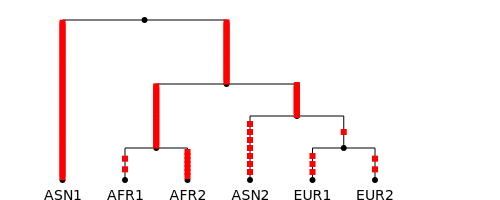

------------------------------------------------------------
(2920.7549588740276, 2939.4746969224148)


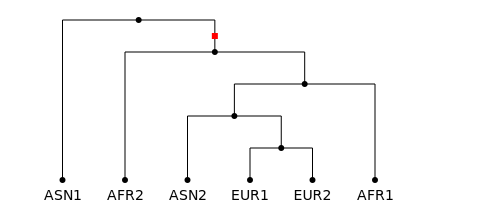

------------------------------------------------------------
(2939.4746969224148, 5000.0)


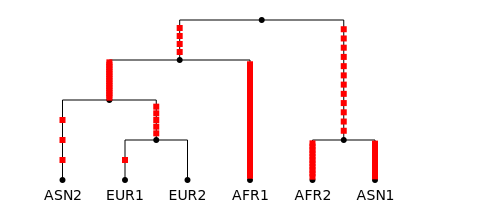

In [13]:
for tree in ooa_inferred_ts.trees():
    print("---"*20)
    print(tree.get_interval())
    display(SVG(tree.draw(mutation_labels={},
        node_labels={0:"AFR1",1:"AFR2", 2:"EUR1",3:"EUR2",4:"ASN1",5:"ASN2"},
        width=500)))
    

Note that the correct relationship between the samples was largely captured in the inferred tree sequence, although we have not picked up changes in the date of internal nodes 

## *P. vivax* Example

We now use tsinfer on real data from the [ *P. vivax* Genome Variation Project](https://www.malariagen.net/projects/p-vivax-genome-variation) containing 228 samples from 13 countries. Joe Zhu ran [Deploid](https://github.com/DEploid-dev/DEploid) on this dataset to identify 124 clonal samples. He then phased and imputed haplotypes for each strain.
<br> 
Since $\texttt{tsinfer}$ requires ancestral and derived alleles, Wilder used [$\texttt{Mauve}$](http://darlinglab.org/mauve/mauve.html) to create a multi-species alignment of the *vivax* genome to outgroups *cynomolgi* ([a sister taxon of *vivax*](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3759362/)) and *knowlesi* (an outgroup of *vivax* and *cynomolgi* ).  A rules-based maximum parsimony approach was used to determine ancestral alleles using this multi-species alignment. Ancestral alleles were only called where the reference call at all three species agreed (~53% of sites), and we only consider these "high-confidence" calls. Better ancestral allele determination methods certainly exist, but this is a simple way to get things working.  
<br>
We have pre-made a SampleData object that $\texttt{tsinfer}$ requires to run Chromosome 1 of the 124 vivax samples. This avoids the gory details of working with VCFs.

In [68]:
vivax_sample_data = tsinfer.load("data/clonal_vivax.samples")

In [69]:
print(vivax_sample_data)

path                  = data/clonal_vivax.samples
file_size             = 128.0 KiB
format_name           = tsinfer-sample-data
format_version        = (1, 0)
finalised             = True
uuid                  = 756856c0-d8a1-4f42-a1f5-da03e5aa02f8
num_provenances       = 0
provenances/timestamp = shape=(0,); dtype=object;
provenances/record    = shape=(0,); dtype=object;
sequence_length       = 789250.0
num_populations       = 15
num_individuals       = 124
num_samples           = 124
num_sites             = 6087
num_inference_sites   = 1896
populations/metadata  = shape=(15,); dtype=object;
individuals/metadata  = shape=(124,); dtype=object;
individuals/location  = shape=(124,); dtype=object;
samples/individual    = shape=(124,); dtype=int32;uncompressed size=496 Bytes
samples/population    = shape=(124,); dtype=int32;uncompressed size=496 Bytes
samples/metadata      = shape=(124,); dtype=object;
sites/position        = shape=(6087,); dtype=float64;uncompressed size=48.7 kB
sites/all

Now let's infer the tree sequence:

In [70]:
vivax_inferred_ts = tsinfer.infer(vivax_sample_data)
vivax_inferred_ts.num_trees

1475

Now let's visualise the first of the 1475 inferred marginal trees.

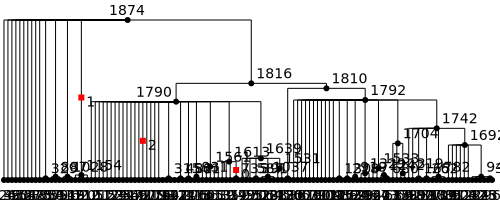

In [71]:
first_tree = vivax_inferred_ts.first()
SVG(first_tree.draw(width=500))

Clearly, with 124 samples, the tree is unintelligible. We can use the powerful [ete3 tree drawing engine](http://etetoolkit.org/docs/latest/tutorial/tutorial_drawing.html) to draw the first tree with a circular output:

<img src="images/circular_vivax_tree.png">


In [72]:
#if you're curious how this tree was created here is the code
#it won't run on jupyter hub however

# first_tree_newick=Tree(first_tree.newick())
# ts = TreeStyle()
# ts.mode = "c"
# ts.arc_start = 0 # 0 degrees = 3 o'clock
# ts.arc_span = 360
# #ts.scale = 20
# ts.show_leaf_name = True
# ts.show_scale = False
# first_tree_newick.render("%%inline",tree_style=ts,w=500)  

This is better, but it would be helpful to know where the samples came from!

Luckily the country of origin of the 124 sequences we are considering was stored in the vivax sample data file. Cleverly, this metadata has been transferred into the inferred tree sequence too, which we can query using the `populations()` iterator:

In [73]:
for p in vivax_inferred_ts.populations():
    print("Sample IDs from population", json.loads(p.metadata)['name'])
    print(vivax_inferred_ts.samples(population=p.id))

Sample IDs from population West Thailand
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50]
Sample IDs from population East Thailand
[51]
Sample IDs from population West Cambodia
[52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71]
Sample IDs from population Northeast Cambodia
[72]
Sample IDs from population Indonesia
[73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96]
Sample IDs from population Papua New Guinea
[ 97  98  99 100 101 102 103 104]
Sample IDs from population Brazil
[105]
Sample IDs from population Sri Lanka
[106]
Sample IDs from population Vietnam
[107 108 109 110 111 112 113]
Sample IDs from population India
[114]
Sample IDs from population Malaysia
[115 116 117 118 119]
Sample IDs from population Myanmar
[120]
Sample IDs from population Laos
[121]
Sample IDs from population Madagascar
[122]
Sample IDs from population China
[123]


We can use these to redraw the tree, coloring the tips by the country of origin. We won't show all the code here as it gets a bit messy, but here is the output:

<img src="images/malaria_circular.png">

This sort of representation at a region of interest could certainly be informative, but with 1475 marginal trees we need other ways to summarize the relationships between samples. 

## Genealogical Nearest Neighbours
A useful metric for understanding population level relationships from a tree sequence is genealogical nearest neighbours. 
Given K sets of reference nodes (e.g., the samples for each of the 15 populations of clonal *vivax* samples), the GNN statistic for a specific node is a K-vector describing the proportion of its immediate neighbours within the tree from each of these reference sets. Think of this as looking at the most recent node, or ancestor, of each sample and determining what population the other daughter sample(s) of that node came from.  
<br>
In the tsinfer preprint, we determined the GNN matrix for the UK Biobank. Here we show a much smaller example from the same clonal *vivax* dataset, removing populations with only one sample. 


We begin by creating the reference set of populations for which the GNN statistic will be calculated.

In [74]:
import json
tables = vivax_inferred_ts.dump_tables()
reference_sets = []

for pop in vivax_inferred_ts.populations():
    reference_sets.append(np.where(tables.nodes.population == pop.id)[0].astype(np.int32))
    name = json.loads(pop.metadata.decode())["name"]

We then run the genealogical_nearest_neighbours function, converting the resulting array into a Pandas DataFrame and adding a Population column.

In [75]:
A = vivax_inferred_ts.genealogical_nearest_neighbours(
vivax_inferred_ts.samples(), reference_sets)
gnn = pd.DataFrame(A)
gnn["Population"] = ""

We create a dictionary listing the samples belonging to each population from the metadata.

In [76]:
pop_dict = {}
for p in vivax_inferred_ts.populations():
    pop_dict[json.loads(p.metadata)['name']] = list(vivax_inferred_ts.samples(population=p.id))

We then use this dictionary to assign a population to each sample and rename the columns by the population they represent.

In [77]:
i = 0
for pop in pop_dict.items():
    for indiv in pop[1]:
        gnn.iloc[i,15] = pop[0]
        i += 1
gnn = gnn.rename(index=str, columns={v: k for v, k in enumerate(list(pop_dict.keys()))})

We keep populations with more than one sample.

In [78]:
gnn_removed_singletons=gnn[gnn["Population"].isin(['West Thailand','Indonesia',"West Cambodia","Papua New Guinea",
                                                   "Vietnam","Malaysia"])]
gnn_small = gnn_removed_singletons[['West Thailand','Indonesia',"West Cambodia","Papua New Guinea",
                                                   "Vietnam","Malaysia","Population"]]


And we determine the Z-score normalised GNN proportions for clonal *vivax* samples by population. 
The GNN matrix is first z-score normalised by column and the rows are then hierarchically clustered.

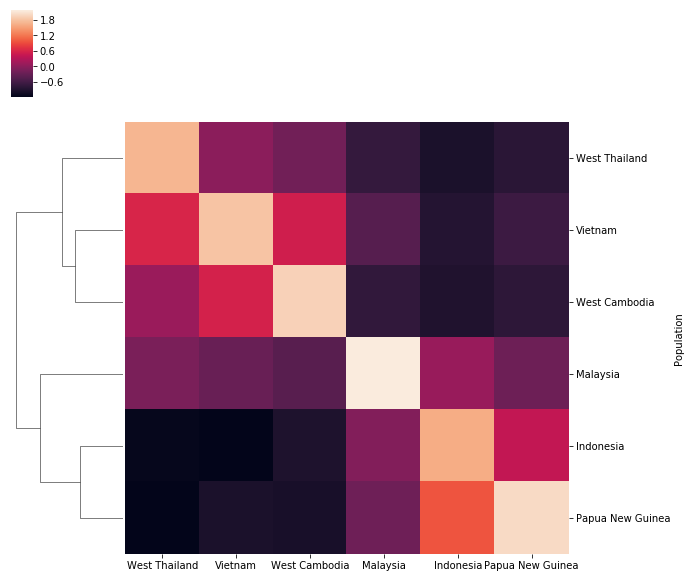

In [82]:
dfg = gnn_small.groupby("Population").mean()

# Zscore normalise
for col in list(dfg):
    dfg[col] = scipy.stats.zscore(dfg[col])

row_linkage = scipy.cluster.hierarchy.linkage(dfg, method="average")
order = scipy.cluster.hierarchy.leaves_list(row_linkage)
x_pop = dfg.index.values[order]

sns.clustermap(dfg[x_pop],row_linkage=row_linkage,col_cluster=False)

<a id='metadata'></a>
# 6. Storing metadata in tree sequences

We have already seen that metadata such as population names can be saved into, and passed between, `SampleData` and  `TreeSequence` objects. Most other objects in a tree sequence can have associated metadata: perhaps the most common use is storing names and locations of individuals or samples, but you can also tag nodes, mutations, sites, etc. 

Another example of metadata storage is [provenance information](https://msprime.readthedocs.io/en/stable/provenance.html), which tells you how the tree sequence was generated. For inferred data, this might include details of the source of the VCF files, and so forth. For simulated data, it should reveal the simulation tool, the specs of the computer used to run the simulations, the simulation parameters, etc. We can peek at these for our previously simulated examples.

In [24]:
import json # arbitrary metadata tends to use JSON formatting

print("\n== Out of Africa simulation with subsequent mutations ==")
for p in tskit.load("data/OOA.trees").provenances():
  rec = json.loads(p.record)
  print("> Simulated using software:", rec['software'],
       "\n> with parameters", rec['parameters'])

print("\n== Forward simulation with selection ==")
for p in tskit.load("data/slim_fixed.trees").provenances():
  rec = json.loads(p.record)
  print("> Simulated using software:", rec['software'],
       "\n> using command", rec['parameters']['command'],
       "\n> Eidos script was:", rec['parameters']['model'])



== Out of Africa simulation with subsequent mutations ==
> Simulated using software: {'name': 'msprime', 'version': '0.6.2'} 
> with parameters {'command': 'simulate', 'random_seed': 11, 'TODO': 'add other simulation parameters'}
> Simulated using software: {'name': 'msprime', 'version': '0.6.2'} 
> with parameters {'command': 'mutate', 'rate': 1e-06, 'random_seed': 1, 'keep': True}

== Forward simulation with selection ==
> Simulated using software: {'name': 'SLiM', 'version': '3.2'} 
> using command ['slim', '-seed', '123', '/var/folders/wc/ywg2jvp92pvbjyc7sqcz_1_m0000gn/T/tmpu2j3qq26'] 
> Eidos script was: 
initialize() {
    initializeTreeSeq();
    initializeMutationRate(1e-08);
    initializeMutationType("m2", 0.5, "g", -0.01, 1.0);  // deleterious
    initializeMutationType("m3", 1.0, "f", 0.05);       // advantageous
    // only deleterious mutations (type m2) should be introduced automatically
    initializeGenomicElementType("g1", m2, 1.0);
    initializeGenomicElement(g1, 0

This should be enough detail to rerun the simulation to obtain the same results

<a id='ref'></a>
# 5. References and Documentation

$\texttt{msprime}$: <br>
Reference: Kelleher, J., Etheridge, A.M. and McVean, G., 2016. Efficient coalescent simulation and genealogical analysis for large sample sizes. PLoS computational biology, 12(5), p.e1004842.
<br>
Documentation: https://msprime.readthedocs.io/en/stable/index.html

$\texttt{SLiM}$: <br>
Reference: Haller, B.C., Galloway, J., Kelleher, J., Messer, P.W. and Ralph, P.L., 2018. Tree‐sequence recording in SL iM opens new horizons for forward‐time simulation of whole genomes. Molecular Ecology Resources.
<br>
Documentation: http://benhaller.com/slim/SLiM_Manual.pdf

$\texttt{tsinfer}$: <br>
Reference:  Kelleher, J., Wong, Y., Albers, P., Wohns, A.W. and McVean, G., 2018. Inferring the ancestry of everyone. bioRxiv, p.458067.
<br>
Documentation: https://tsinfer.readthedocs.io/en/latest/api.html?highlight=sample_data

Out of Africa Model used in section 3: <br>
Gutenkunst, R.N., Hernandez, R.D., Williamson, S.H. and Bustamante, C.D., 2009. Inferring the joint demographic history of multiple populations from multidimensional SNP frequency data. PLoS genetics, 5(10), p.e1000695.